In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
import csv
import seaborn as sns
plt.rc('figure', figsize=[12,8])

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Import data, PCA, K-means

In [2]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

traindf.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
testdf.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
xdata = traindf.drop(['label'], axis=1).values
ydata = traindf['label'].values

pca = PCA(n_components=50)
pca.fit(xdata)
print(sum(pca.explained_variance_ratio_))

0.82555225918


In [5]:
X = pca.transform(xdata)
ypred = KMeans(n_clusters=10).fit_predict(X)

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


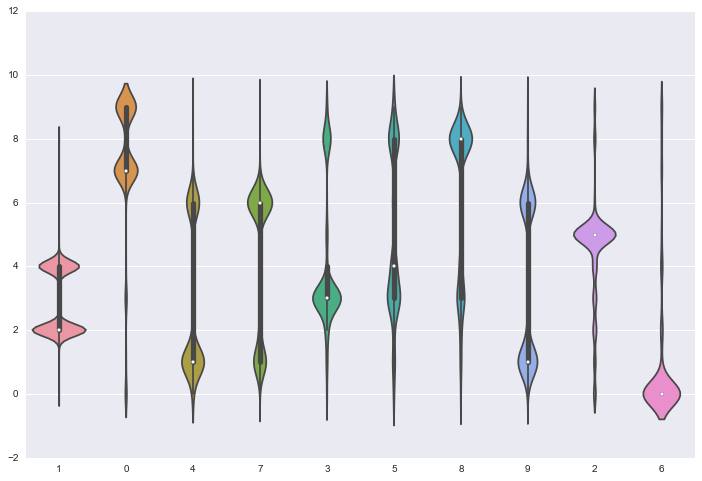

In [6]:
sns.violinplot(ydata, ypred)

Looks like K-means clustering is ineffective (clusters are probably different sizes) - maybe knn will be better.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
neigh.fit(X, ydata) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

# KNN

In [8]:
scores = []
for train, test in KFold(n=len(ydata), n_folds=4, shuffle=True):
    neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    neigh.fit(X[train], ydata[train])
    scores.append(neigh.score(X[test], ydata[test]))
print scores

[0.97228571428571431, 0.97371428571428575, 0.97209523809523812, 0.97361904761904761]


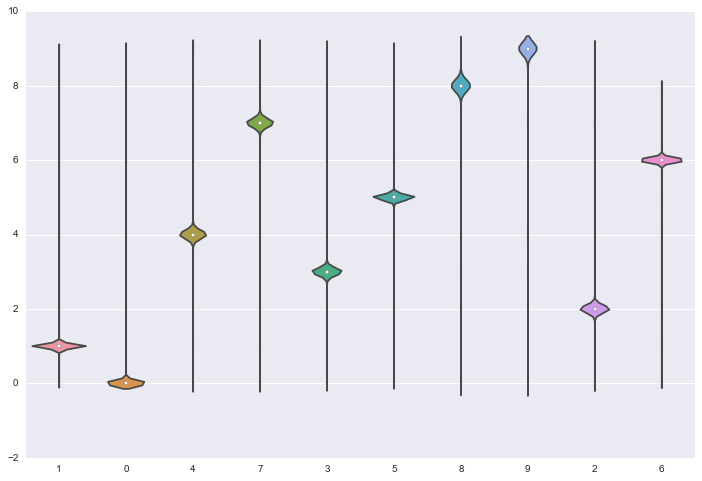

In [9]:
sns.violinplot(ydata, neigh.predict(X))

Looks good!

In [10]:
testdata = testdf.values
XVal = pca.transform(testdata)
predictions = neigh.predict(XVal)

ImageId = range(1, len(predictions)+1)

predictions_file = open("avrknn.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(['ImageId', 'Label'])
open_file_object.writerows(zip(ImageId, predictions))
predictions_file.close()

# Neural net

In [11]:
# Try a neural network
import pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet

ydata_net = np.zeros([len(ydata), 10])
for i, y in enumerate(ydata):
    ydata_net[i, y] = 1
    
ds = SupervisedDataSet(len(XVal[0]), 10)

for i, j in zip(X, ydata_net):
    ds.addSample(i, j)
    
net = buildNetwork(len(X[0]), 15, 10, bias=True)
trainer = BackpropTrainer(net, ds)

for i in range(20):
    print trainer.train()

output = [net.activate(d) for d in X]
predictions = [i.argmax() for i in output]
matches = (predictions == ydata)
accuracy = float(matches.sum()) / float(len(matches))
print accuracy

0.045888933348
0.0323042082416
0.0308602353637
0.0297198396658
0.0289344473551
0.0283040528805
0.0276594724729
0.027161983671
0.0270820164192
0.026609655236
0.0262350455362
0.0257004698261
0.0253869058455
0.0250307264926
0.0248602725969
0.0245197342425
0.0240018335742
0.0238242963765
0.0233762915043
0.0235002913577
0.801142857143


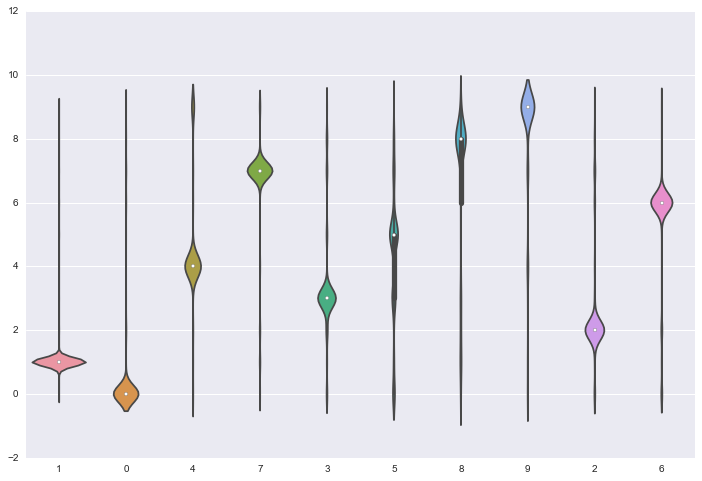

In [12]:
sns.violinplot(ydata, predictions)

Neural net appears to struggle with accurately identifying 4, 5, 8.